# `Project Dependencies`

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00


# `Project Code`

Updated Project Code With detokenisation

In [3]:
from transformers import AutoTokenizer
from datasets import load_dataset
import time

# byte_pair_tokenization = ["openai-gpt", "gpt2", "NousResearch/Llama-2-13b-hf"]
# unigram_tokenization = ["google/bigbird-roberta-base", "facebook/mbart-large-50-many-to-many-mmt" , "albert-base-v2" , "xlnet-base-cased"]
# wordpiece_tokenization = ['distilbert-base-uncased','google/mobilebert-uncased','funnel-transformer/small-base','sentence-transformers/all-mpnet-base-v2']
# sentencepiece_tokenization = ["google/flan-t5-base"]

#corpus = ["I have a new GPU!", "I wonder how fast the model will train on this.","Hello there"]

dataset = load_dataset("HuggingFaceH4/self-instruct-seed")
corpus = dataset['train']['instruction']
dataset2 = load_dataset("fka/awesome-chatgpt-prompts")
corpus2 = dataset2['train']['prompt']

def initialize_model(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer

#Unbatched data
def time_model(tokenizer_object, text, tokenize=True):
    if tokenize:
        # Capture the start time
        start_time = time.time()
        tokenizer_object.encode_plus(text)
    else:
        tokens = tokenizer_object.encode_plus(text)
        # Capture the start time
        start_time = time.time()
        tokenizer_object.decode(tokens['input_ids'], skip_special_tokens=True)

    # Capture the end time
    end_time = time.time()
    # Calculate the elapsed time in milliseconds
    elapsed_time = (end_time - start_time) * 1e3
    return elapsed_time

def analyse_encode_plus(tokenizers: list, corpus: list) -> dict:
    results = {}
    results['method'] = "Unbatched"

    for hugging_face_tokenizer in tokenizers:
        try:
            tokenizer = initialize_model(hugging_face_tokenizer)
            total_time_tokenization = 0  # Total time for tokenization
            total_time_detokenization = 0  # Total time for detokenization

            for text in corpus:
                # Tokenize each line in the corpus individually
                tokenization_time = time_model(tokenizer, text, tokenize=True)
                total_time_tokenization += tokenization_time

                # Detokenize the encoded text
                detokenization_time = time_model(tokenizer, text, tokenize=False)
                total_time_detokenization += detokenization_time

            # Extract tokenizer name or path for dictionary key
            tokenizer_name = tokenizer.name_or_path
            results[tokenizer_name] = {
                "Tokenization": total_time_tokenization,
                "Detokenization": total_time_detokenization
            }

            print(f"{tokenizer_name}:")
            print(f"Tokenization Time: {total_time_tokenization} ms")
            print(f"Detokenization Time: {total_time_detokenization} ms")
        except Exception as e:
            print(f"Error occurred for {hugging_face_tokenizer}: {e}")
            continue

    return results

def time_model_batch(tokenizer, corpus,tokenize=True):

    if tokenize:
        # Capture the start time
        start_time = time.time()
        tokenizer.batch_encode_plus(corpus)
    else:
        tokens = tokenizer.batch_encode_plus(corpus)
        # Capture the start time
        start_time = time.time()
        tokenizer.batch_decode(tokens['input_ids'], skip_special_tokens=True)

    # Capture the end time
    end_time = time.time()
    # Calculate the elapsed time in milliseconds
    elapsed_time = (end_time - start_time) * 1e3
    return elapsed_time

def analyse_batch(tokenizers: list, corpus: list) -> dict:
    results = {}
    results['method'] = "Batched"
    for hugging_face_tokenizer in tokenizers:
        tokenizer = initialize_model(hugging_face_tokenizer)
        try:
            #get time for tokenization
            tokenization_time = time_model_batch(tokenizer, corpus, tokenize=True)
            #get time for detokenization
            detokenization_time = time_model_batch(tokenizer, corpus,tokenize=False)

            # Extract tokenizer name or path for dictionary key
            tokenizer_name = tokenizer.name_or_path
            results[tokenizer_name] = {
                "Tokenization": tokenization_time,
                "Detokenization": detokenization_time
            }

            print(f"{tokenizer_name}:")
            print(f"Tokenization Time: {tokenization_time} ms")
            print(f"Detokenization Time: {detokenization_time} ms")
        except Exception as e:
          print(f"Error occured for {hugging_face_tokenizer}: {e}")
          continue

    return results


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Openai , Gpt2 , Llama Analysis for Unbatched and Batched data

In [5]:
byte_pair = ["openai-gpt", "gpt2", "NousResearch/Llama-2-13b-hf"]
print("--------------------------Unbatched Data-------------------------------")
byte_pair_timing_unbatched = analyse_encode_plus(byte_pair, corpus)
print("--------------------------Batched Data-------------------------------")
byte_pair_timing_batched = analyse_batch(byte_pair,corpus)

--------------------------Unbatched Data-------------------------------


openai-gpt:
Tokenization Time: 23.493051528930664 ms
Detokenization Time: 8274.685621261597 ms


gpt2:
Tokenization Time: 28.712749481201172 ms
Detokenization Time: 27.922868728637695 ms


NousResearch/Llama-2-13b-hf:
Tokenization Time: 25.57992935180664 ms
Detokenization Time: 33.15925598144531 ms
--------------------------Batched Data-------------------------------
openai-gpt:
Tokenization Time: 13.199567794799805 ms
Detokenization Time: 21.755695343017578 ms
gpt2:
Tokenization Time: 12.187004089355469 ms
Detokenization Time: 22.495746612548828 ms
NousResearch/Llama-2-13b-hf:
Tokenization Time: 19.573211669921875 ms
Detokenization Time: 25.72464942932129 ms


## Distilbert-base-uncased , mobilebert-uncased , Funnel Transformers, Mpnet Analysis for Unbatched and Batched Data

In [6]:
# Get response time for word_piece models
word_piece =['distilbert-base-uncased','google/mobilebert-uncased','funnel-transformer/small-base','sentence-transformers/all-mpnet-base-v2']
print("--------------------------Unbatched Data-------------------------------")
word_piece_timing_unbatched = analyse_encode_plus(word_piece, corpus)
print("--------------------------Batched Data-------------------------------")
word_piece_timing_batched = analyse_batch(word_piece,corpus)

--------------------------Unbatched Data-------------------------------


distilbert-base-uncased:
Tokenization Time: 20.777463912963867 ms
Detokenization Time: 30.34043312072754 ms


google/mobilebert-uncased:
Tokenization Time: 40.883779525756836 ms
Detokenization Time: 60.217857360839844 ms


funnel-transformer/small-base:
Tokenization Time: 46.176910400390625 ms
Detokenization Time: 58.12668800354004 ms


sentence-transformers/all-mpnet-base-v2:
Tokenization Time: 38.57779502868652 ms
Detokenization Time: 55.46879768371582 ms
--------------------------Batched Data-------------------------------
distilbert-base-uncased:
Tokenization Time: 23.650646209716797 ms
Detokenization Time: 51.604509353637695 ms
google/mobilebert-uncased:
Tokenization Time: 24.36375617980957 ms
Detokenization Time: 59.2188835144043 ms
funnel-transformer/small-base:
Tokenization Time: 25.062084197998047 ms
Detokenization Time: 53.345441818237305 ms
sentence-transformers/all-mpnet-base-v2:
Tokenization Time: 22.535324096679688 ms
Detokenization Time: 50.11463165283203 ms


## T5 Unbatched and Batch data analysis

In [7]:
sentence_piece = ["google/flan-t5-base"]
sentence_piece_timing_unbatched = analyse_encode_plus(sentence_piece, corpus)
sentence_piece_timing_batched = analyse_batch(sentence_piece,corpus)

google/flan-t5-base:
Tokenization Time: 25.575637817382812 ms
Detokenization Time: 27.791738510131836 ms
google/flan-t5-base:
Tokenization Time: 12.306928634643555 ms
Detokenization Time: 31.30030632019043 ms


## BigBird , MBart , Albertbase , xlnet Unbatched and Batched Data Analysis

In [8]:
unigram = ["google/bigbird-roberta-base", "facebook/mbart-large-50-many-to-many-mmt" , "albert-base-v2" , "xlnet-base-cased"]
print("--------------------------Unbatched Data-------------------------------")
unigram_timing_unbatched = analyse_encode_plus(unigram, corpus)
print("--------------------------Batched Data-------------------------------")
unigram_timing_batched = analyse_batch(unigram,corpus)

--------------------------Unbatched Data-------------------------------


google/bigbird-roberta-base:
Tokenization Time: 27.57859230041504 ms
Detokenization Time: 26.61442756652832 ms


facebook/mbart-large-50-many-to-many-mmt:
Tokenization Time: 151.6892910003662 ms
Detokenization Time: 30.620336532592773 ms


albert-base-v2:
Tokenization Time: 35.043954849243164 ms
Detokenization Time: 28.378963470458984 ms


xlnet-base-cased:
Tokenization Time: 52.73580551147461 ms
Detokenization Time: 51.836490631103516 ms
--------------------------Batched Data-------------------------------
google/bigbird-roberta-base:
Tokenization Time: 30.538082122802734 ms
Detokenization Time: 48.86460304260254 ms
facebook/mbart-large-50-many-to-many-mmt:
Tokenization Time: 15.63262939453125 ms
Detokenization Time: 25.79474449157715 ms
albert-base-v2:
Tokenization Time: 22.562503814697266 ms
Detokenization Time: 28.647899627685547 ms
xlnet-base-cased:
Tokenization Time: 16.327857971191406 ms
Detokenization Time: 32.05275535583496 ms


## Graph Analysis for Byte-Pair Encoding , WordPiece ,Unigram and Sentence Piece Unbatched and Batched Data

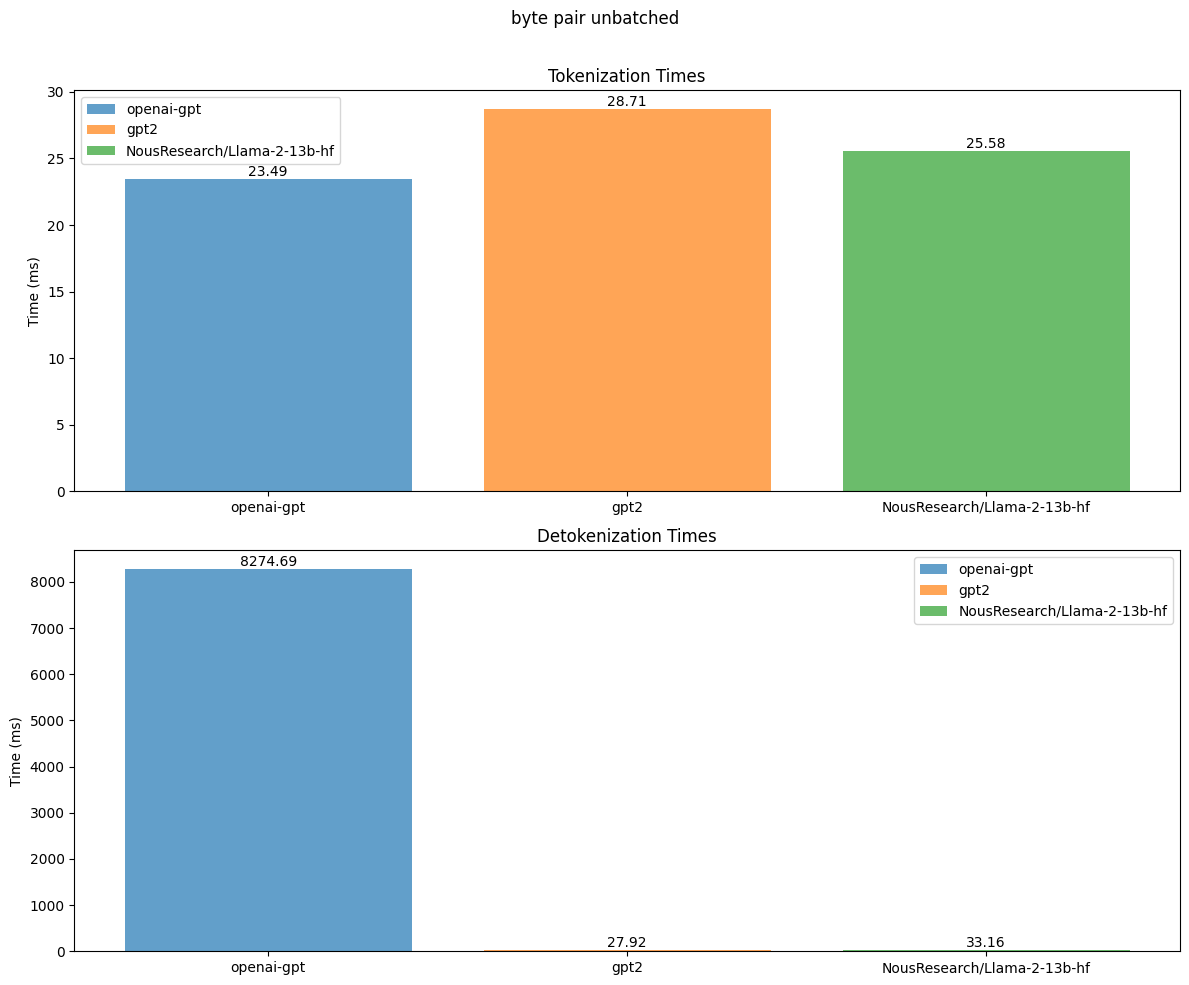

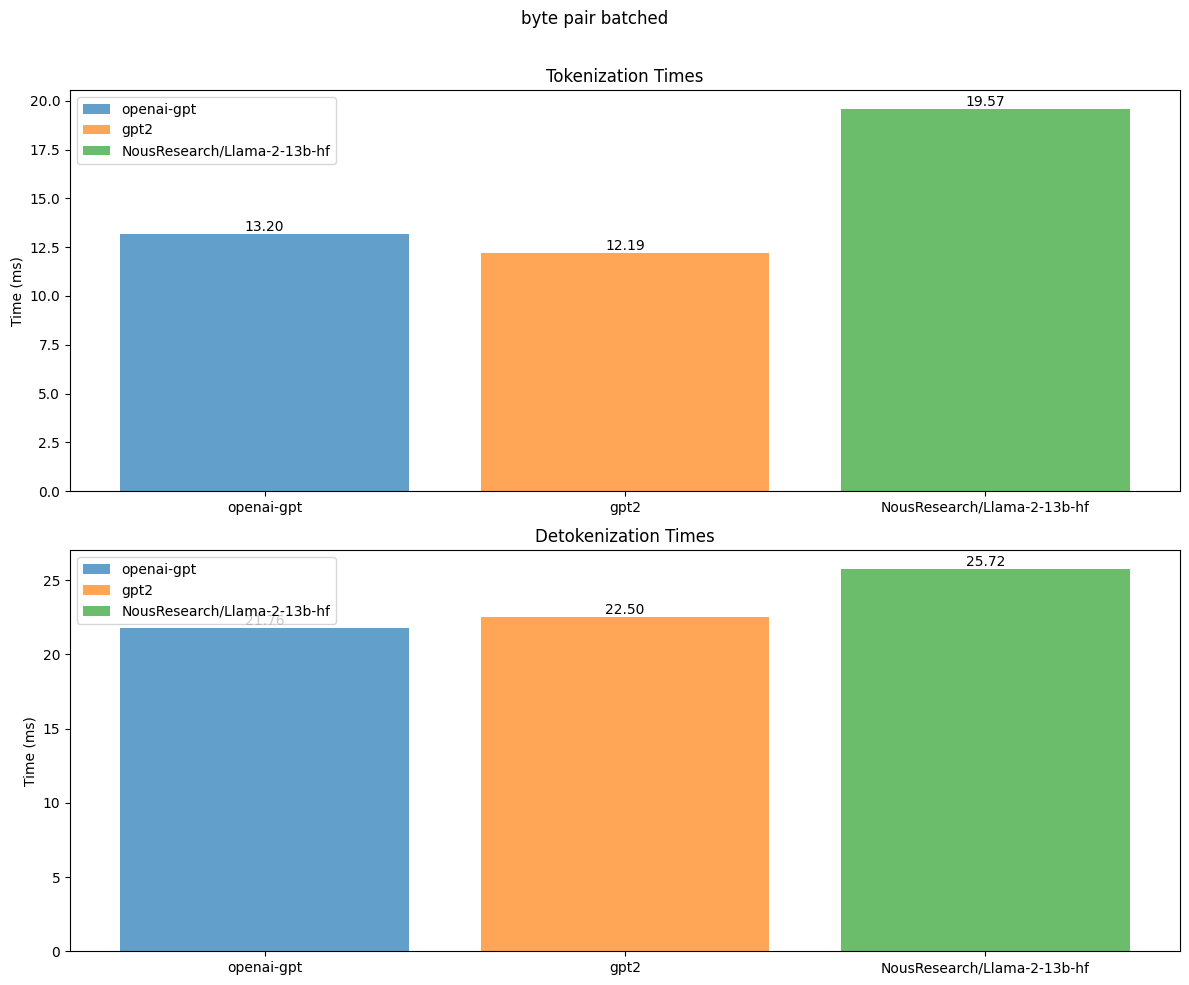

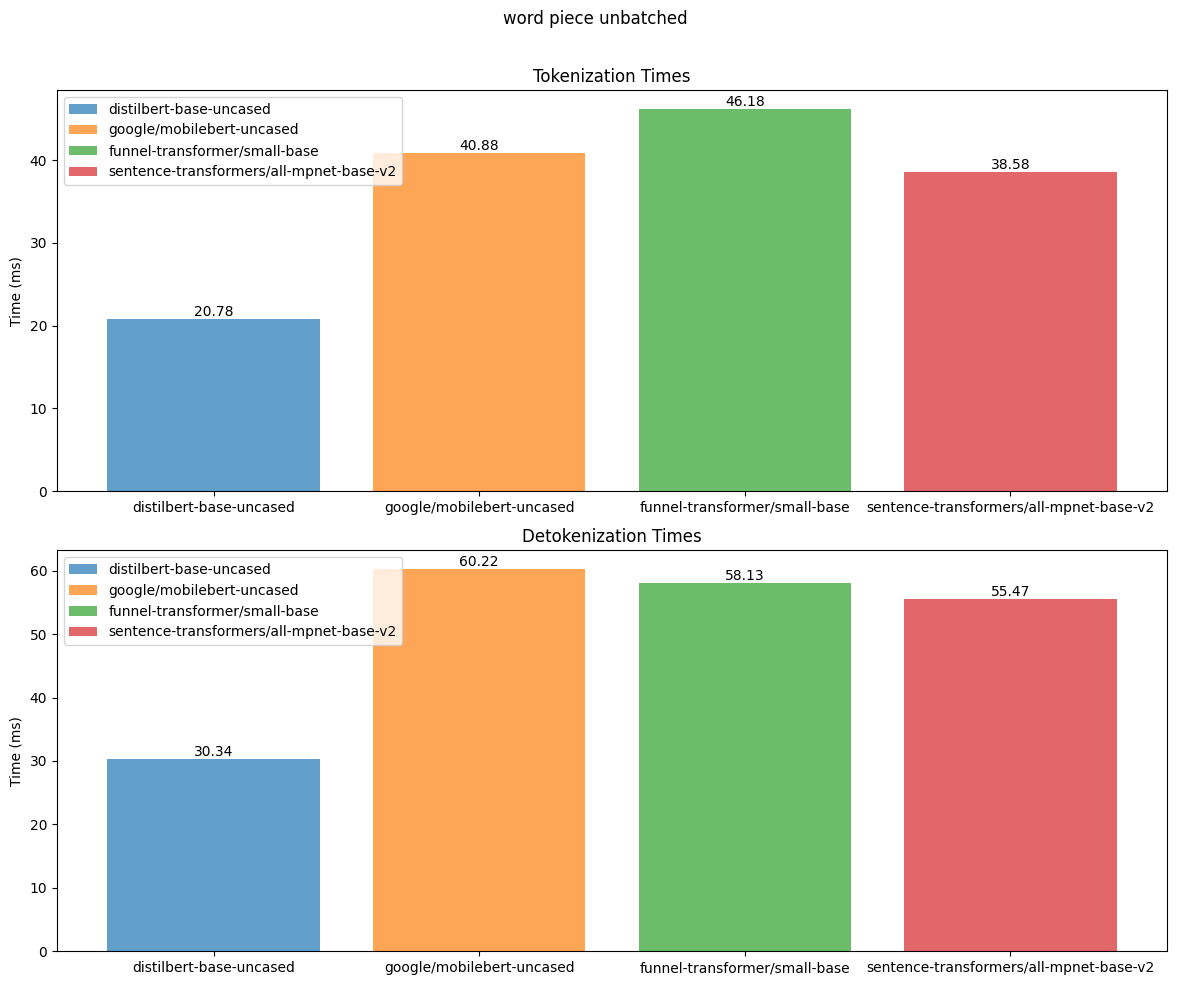

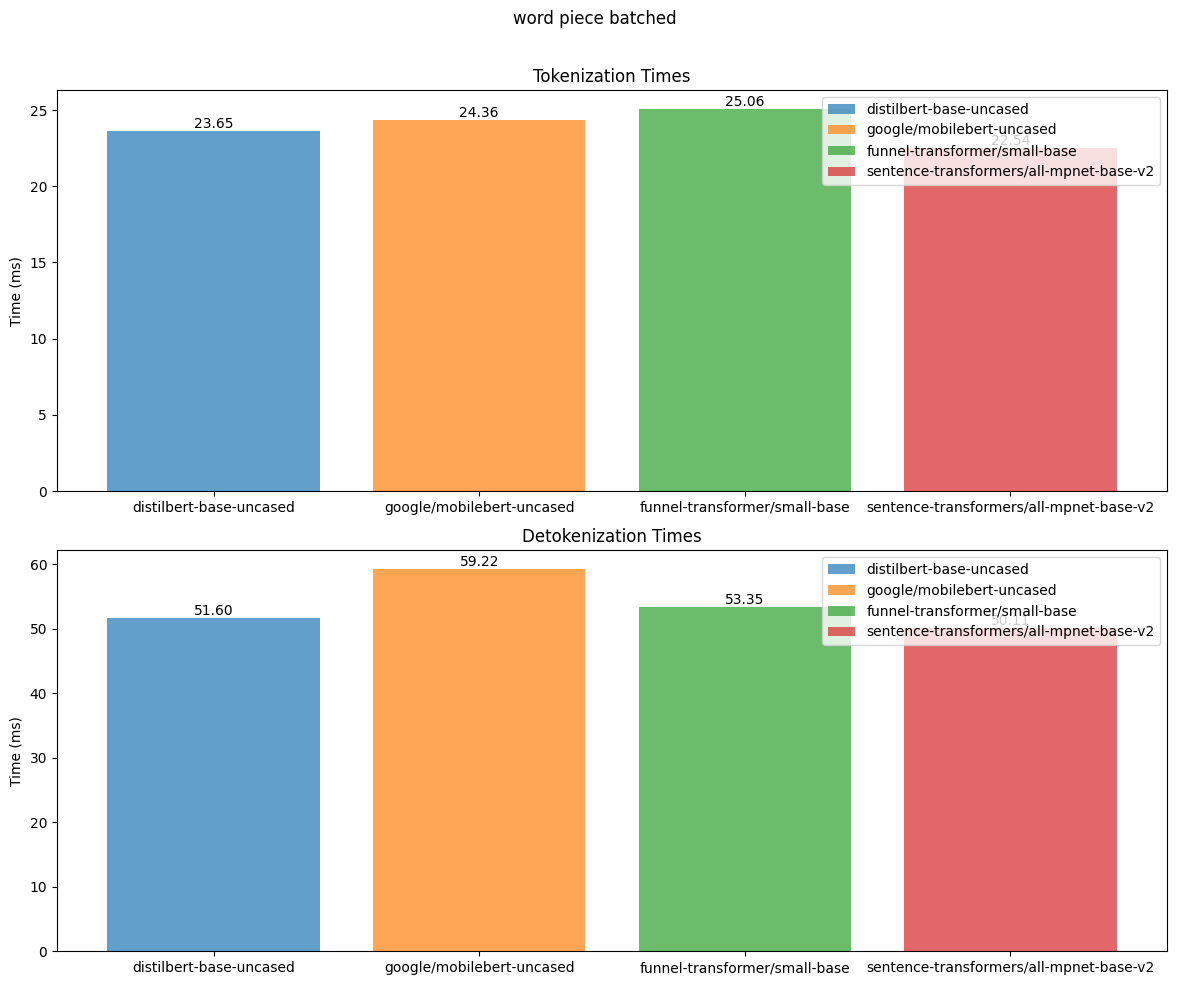

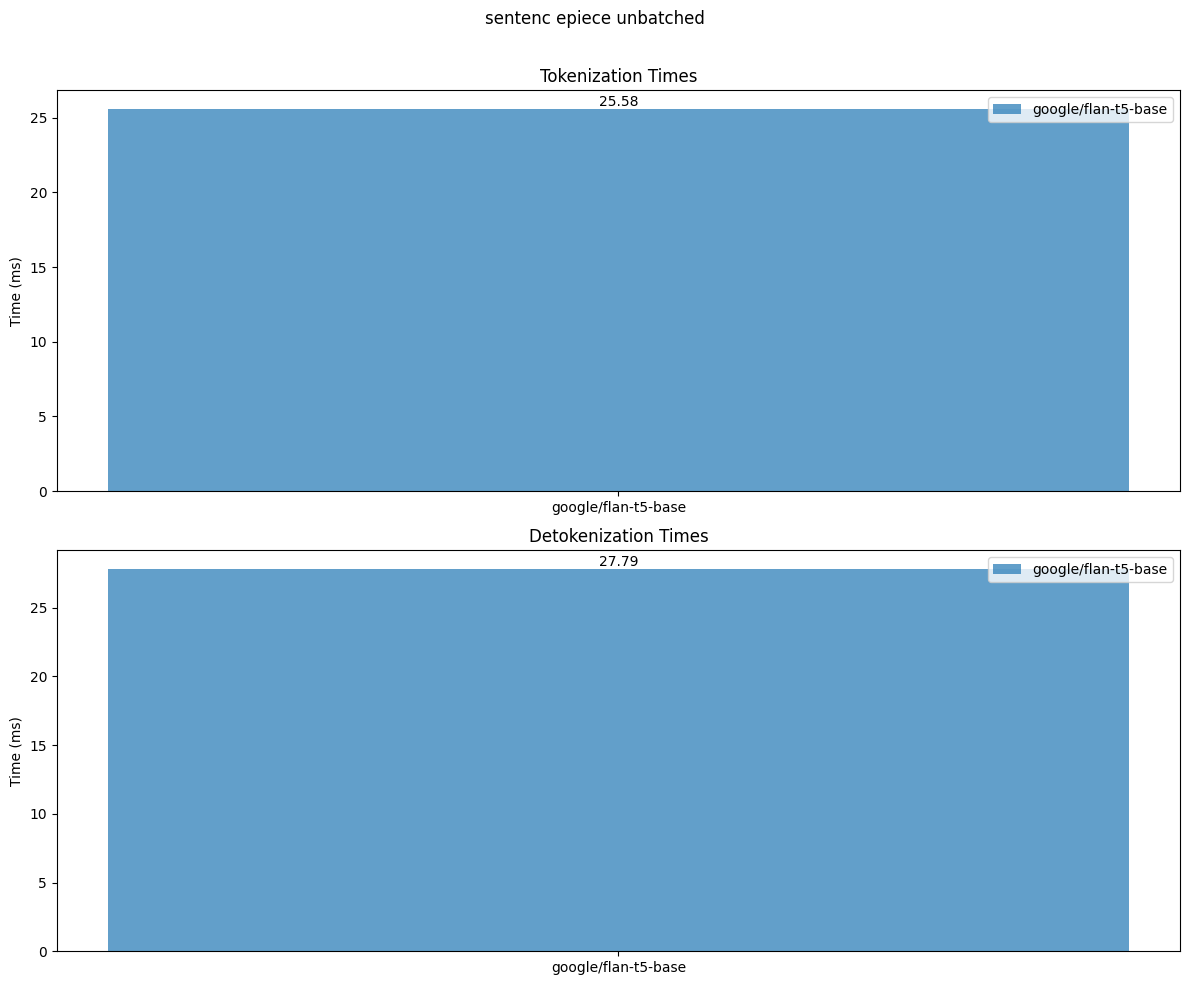

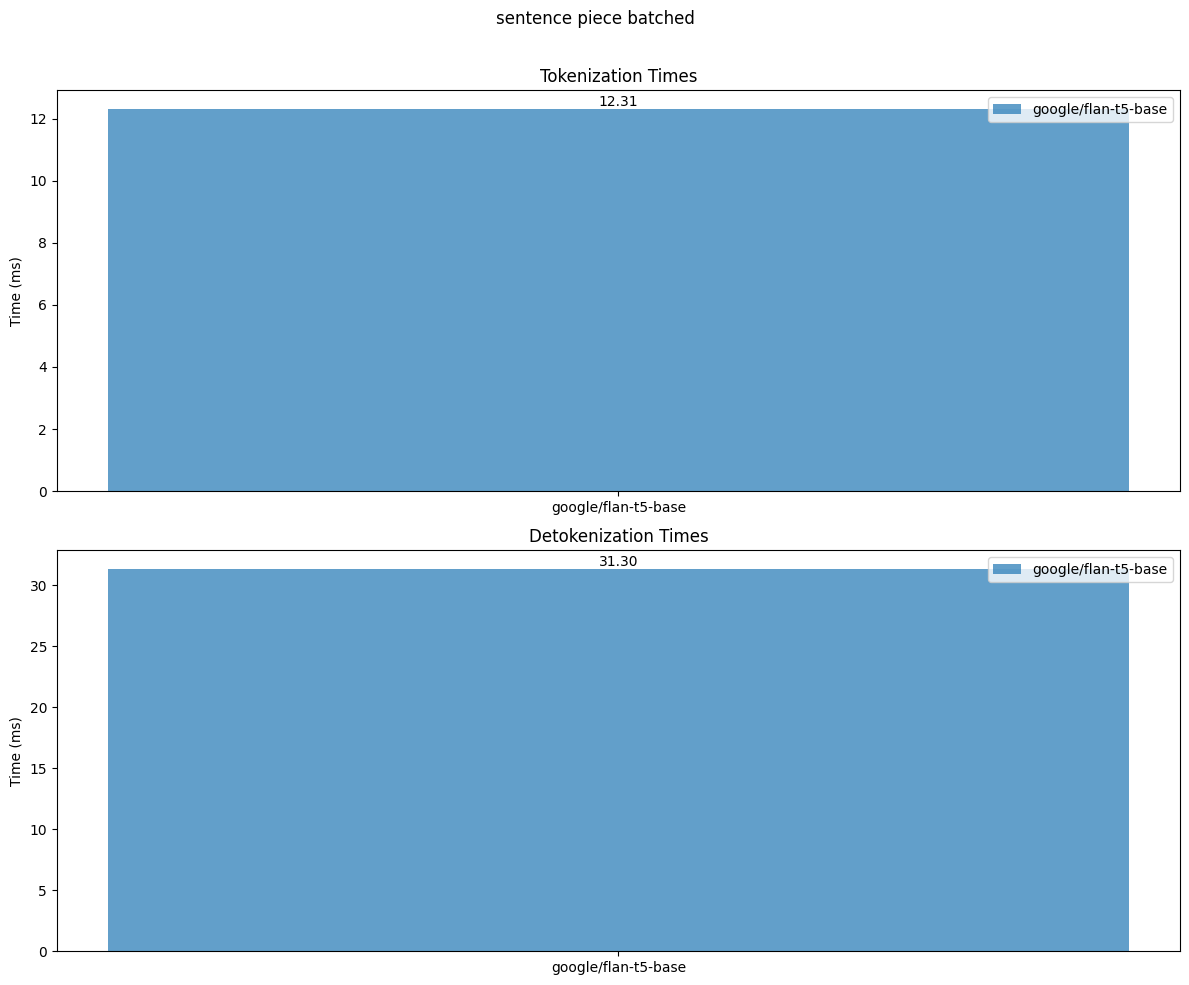

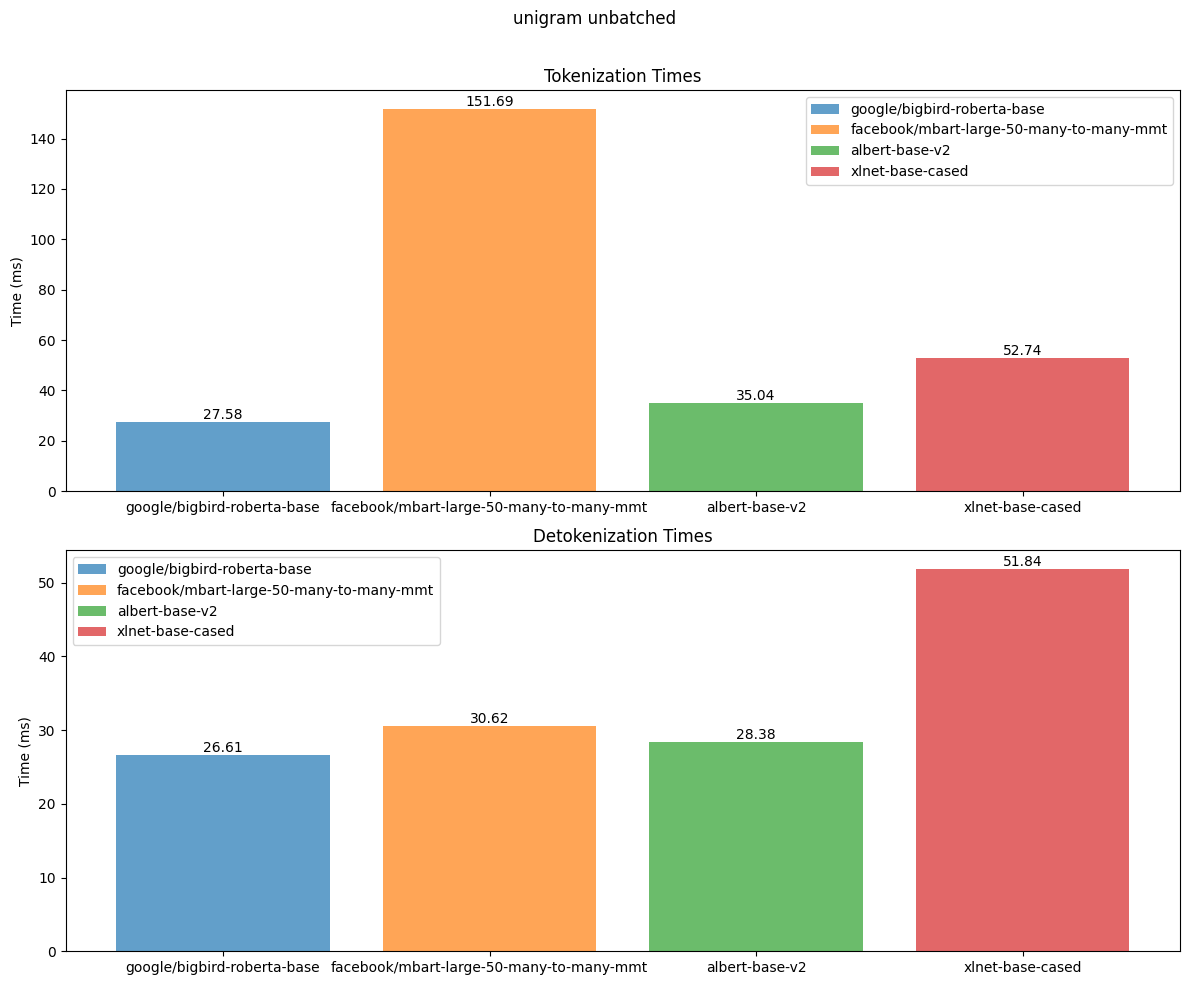

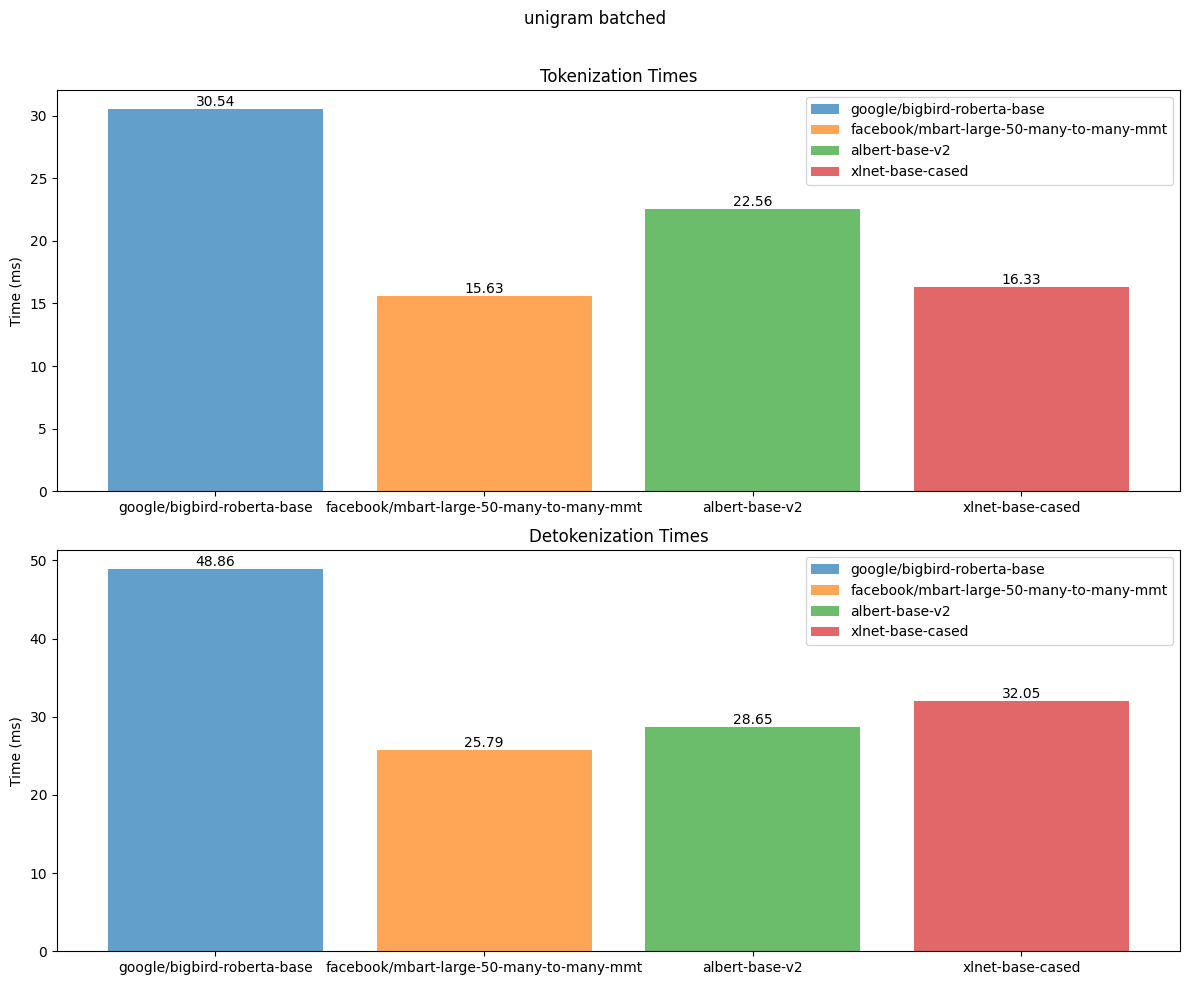

In [9]:
import matplotlib.pyplot as plt


def plot_dict(data_dict, title=''):
    # Extract method names and labels for the x-axis
    methods = list(data_dict.keys())
    x_labels = [f"{method}" for method in methods]

    # Create subplots for tokenization and detokenization times
    fig, axs = plt.subplots(2, figsize=(12, 10))
    fig.suptitle(title)

    for key, value in data_dict.items():
        if key == "method":
            continue

        # Plot tokenization times
        tokenization_time = value.get('Tokenization', 0.0)
        axs[0].bar(key, tokenization_time, label=key, alpha=0.7)

        # Plot detokenization times
        detokenization_time = value.get('Detokenization', 0.0)
        axs[1].bar(key, detokenization_time, label=key, alpha=0.7)

        # Add text labels on top of the bars
        axs[0].annotate(f'{tokenization_time:.2f}', (key, tokenization_time),
                            ha='center', va='bottom')
        axs[1].annotate(f'{detokenization_time:.2f}', (key, detokenization_time),
                            ha='center', va='bottom')

    # Set labels and titles
    axs[0].set_ylabel('Time (ms)')
    axs[0].set_title('Tokenization Times')
    axs[0].legend()

    axs[1].set_ylabel('Time (ms)')
    axs[1].set_title('Detokenization Times')
    axs[1].legend()

    # Show the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    print("\n\n\n\n")

plot_dict(byte_pair_timing_unbatched, "byte pair unbatched")
plot_dict(byte_pair_timing_batched, "byte pair batched")
plot_dict(word_piece_timing_unbatched, "word piece unbatched")
plot_dict(word_piece_timing_batched, "word piece batched")
plot_dict(sentence_piece_timing_unbatched, "sentenc epiece unbatched")
plot_dict(sentence_piece_timing_batched, "sentence piece batched")
plot_dict(unigram_timing_unbatched, "unigram unbatched")
plot_dict(unigram_timing_batched, "unigram batched")

##Translation of corpus

In [11]:
from transformers import M2M100ForConditionalGeneration, AutoTokenizer

def translate(corpus,language):
    # Load the pre-trained model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("facebook/m2m100_418M", src_lang="en")
    model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")

    # Initialize an empty list to store the translated sentences
    translated_corpus = []

    # Loop through each sentence in the input corpus
    for sentence in corpus:
        # Tokenize and encode the English sentence
        encoded_en = tokenizer(sentence, return_tensors="pt")

        # Generate the translation to Chinese
        generated_tokens = model.generate(**encoded_en, forced_bos_token_id=tokenizer.get_lang_id(language))

        # Decode the generated tokens back to text
        translated_sentence = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

        #Print translated_sentence
        print(translated_sentence)

        # Append the translated sentence to the result list
        translated_corpus.append(translated_sentence)

    return translated_corpus


In [14]:
chinese_corpus = translate(corpus2,"zh")
# Save the translations to a text file
with open("corpus_2_chinese.txt", "w", encoding="utf-8") as file:
    for translation in chinese_corpus:
        file.write(translation + "\n")

print("Translations saved to 'corpus_2_chinese.txt'.")

我希望你作为一个Linux终端行动,我会输入命令,你会回答什么终端应该显示,我希望你只用终端输出在一个独特的代码块内回复,没有别的东西,不要写解释,不要输入命令,除非我指示你这样做。


KeyboardInterrupt: ignored

##Other languages

In [15]:
def read_from_file(name):
  # Open the file for reading
  with open(name, 'r') as file:
      # Read all lines from the file and store them in a list
      lines = [line.strip() for line in file]
      return lines
zh1_array = read_from_file("corpus_1_chinese.txt")
zh2_array = read_from_file("corpus_2_chinese.txt")
es1_array = read_from_file("corpus_1_espanol.txt")
es2_array = read_from_file("corpus_2_espanol.txt")

chinese_models = ["bert-base-chinese", "bert-base-multilingual-cased", "OpenBuddy/openbuddy-llama2-70b-v10.1-bf16", "distilbert-base-multilingual-cased", "xlm-roberta-base"]
spanish_models = ["bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"]

##Chinese Tokenization and Detokenization

In [17]:
print("--------------------------Unbatched Chinese Corpus 1 Data-------------------------------")
chinese_corpus1_timing_unbatched = analyse_encode_plus(chinese_models, zh1_array)
print("--------------------------Batched Chinese Corpus 1 Data-------------------------------")
chinese_corpus1_timing_batched = analyse_batch(chinese_models,zh1_array)
print("--------------------------Unbatched Chinese Corpus 2 Data-------------------------------")
chinese_corpus2_timing_unbatched = analyse_encode_plus(chinese_models, zh2_array)
print("--------------------------Batched Chinese Corpus 2 Data-------------------------------")
chinese_corpus2_timing_batched = analyse_batch(chinese_models,zh2_array)

--------------------------Unbatched Chinese Corpus 1 Data-------------------------------
bert-base-chinese:
Tokenization Time: 34.92856025695801 ms
Detokenization Time: 72.86190986633301 ms
bert-base-multilingual-cased:
Tokenization Time: 42.307376861572266 ms
Detokenization Time: 73.17757606506348 ms
OpenBuddy/openbuddy-llama2-70b-v10.1-bf16:
Tokenization Time: 24.857282638549805 ms
Detokenization Time: 61.40494346618652 ms
distilbert-base-multilingual-cased:
Tokenization Time: 36.78488731384277 ms
Detokenization Time: 84.03849601745605 ms
xlm-roberta-base:
Tokenization Time: 49.80182647705078 ms
Detokenization Time: 50.73904991149902 ms
{'method': 'Unbatched', 'bert-base-chinese': {'Tokenization': 34.92856025695801, 'Detokenization': 72.86190986633301}, 'bert-base-multilingual-cased': {'Tokenization': 42.307376861572266, 'Detokenization': 73.17757606506348}, 'OpenBuddy/openbuddy-llama2-70b-v10.1-bf16': {'Tokenization': 24.857282638549805, 'Detokenization': 61.40494346618652}, 'distil

## Unbatched Chinese Corpus 1 Data Graph Analysis

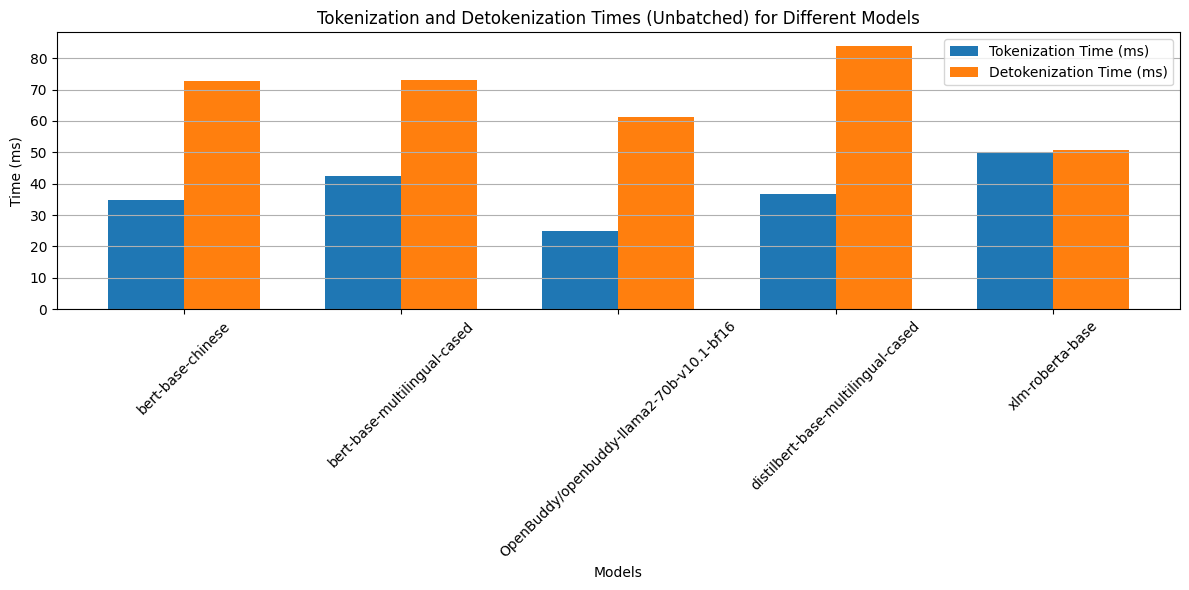

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = [
    'bert-base-chinese',
    'bert-base-multilingual-cased',
    'OpenBuddy/openbuddy-llama2-70b-v10.1-bf16',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base'
]

tokenization_times = [
    chinese_corpus1_timing_unbatched[model]['Tokenization'] for model in models
]

detokenization_times = [
    chinese_corpus1_timing_unbatched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Different Models')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


## Batched Chinese Corpus 1 Graph Analysis(Bar Chart)

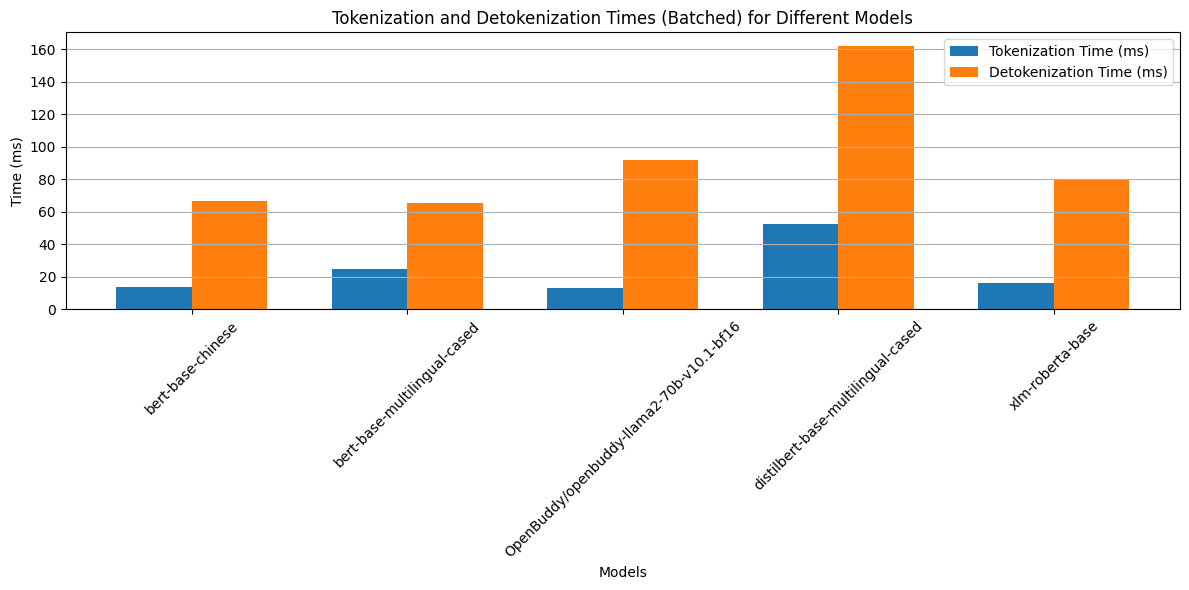

In [20]:

# Data
models = [
    'bert-base-chinese',
    'bert-base-multilingual-cased',
    'OpenBuddy/openbuddy-llama2-70b-v10.1-bf16',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base'
]

tokenization_times = [
    chinese_corpus1_timing_batched[model]['Tokenization'] for model in models
]

detokenization_times = [
    chinese_corpus1_timing_batched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Batched) for Different Models')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


## Graph Analysis For Chinese Corpus 2 batched

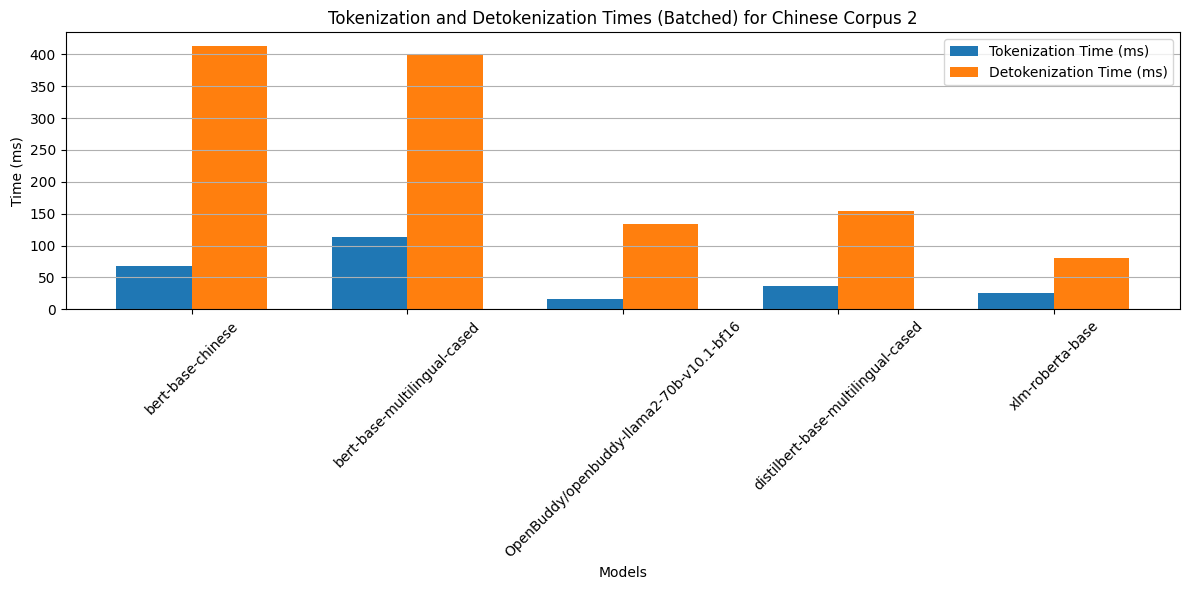

In [25]:

# Data for chinese_corpus2_timing_batched
models = [
    'bert-base-chinese',
    'bert-base-multilingual-cased',
    'OpenBuddy/openbuddy-llama2-70b-v10.1-bf16',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base'
]

tokenization_times_batched = [
    chinese_corpus2_timing_batched[model]['Tokenization'] for model in models
]

detokenization_times_batched = [
    chinese_corpus2_timing_batched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

# Create bar chart for chinese_corpus2_timing_batched
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_batched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_batched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Batched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


## Graph Analysis For Chinese Corpus 2 Unbatched

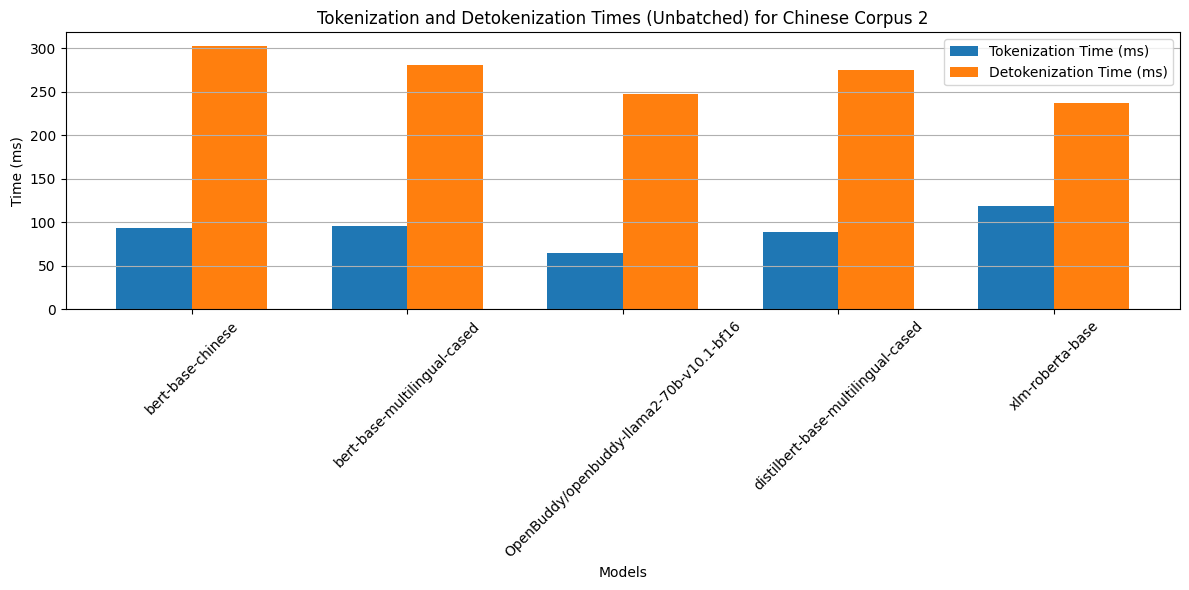

In [27]:
# Data for chinese_corpus2_timing_unbatched
models = [
    'bert-base-chinese',
    'bert-base-multilingual-cased',
    'OpenBuddy/openbuddy-llama2-70b-v10.1-bf16',
    'distilbert-base-multilingual-cased',
    'xlm-roberta-base'
]

tokenization_times_unbatched = [
    chinese_corpus2_timing_unbatched[model]['Tokenization'] for model in models
]

detokenization_times_unbatched = [
    chinese_corpus2_timing_unbatched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

# Create bar chart for chinese_corpus2_timing_unbatched
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_unbatched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_unbatched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


##Spanish Tokenization and Detokenization

In [34]:
print("--------------------------Unbatched Spanish Corpus 1 Data-------------------------------")
spanish_corpus1_timing_unbatched = analyse_encode_plus(spanish_models, es1_array)
print(spanish_corpus1_timing_unbatched)
print("--------------------------Batched Spanish Corpus 1 Data-------------------------------")
spanish_corpus1_timing_batched = analyse_batch(spanish_models,es1_array)
print("--------------------------Unbatched Spanish Corpus 2 Data-------------------------------")
spanish_corpus2_timing_unbatched = analyse_encode_plus(spanish_models, es2_array)
print("--------------------------Batched Spanish Corpus 2 Data-------------------------------")
spanish_corpus2_timing_batched = analyse_batch(spanish_models,es2_array)

--------------------------Unbatched Spanish Corpus 1 Data-------------------------------
bert-base-multilingual-cased:
Tokenization Time: 37.08600997924805 ms
Detokenization Time: 85.80398559570312 ms
distilbert-base-multilingual-cased:
Tokenization Time: 78.83524894714355 ms
Detokenization Time: 122.6038932800293 ms
xlm-roberta-base:
Tokenization Time: 71.43616676330566 ms
Detokenization Time: 110.28766632080078 ms
{'method': 'Unbatched', 'bert-base-multilingual-cased': {'Tokenization': 37.08600997924805, 'Detokenization': 85.80398559570312}, 'distilbert-base-multilingual-cased': {'Tokenization': 78.83524894714355, 'Detokenization': 122.6038932800293}, 'xlm-roberta-base': {'Tokenization': 71.43616676330566, 'Detokenization': 110.28766632080078}}
--------------------------Batched Spanish Corpus 1 Data-------------------------------
bert-base-multilingual-cased:
Tokenization Time: 42.04535484313965 ms
Detokenization Time: 89.9055004119873 ms
distilbert-base-multilingual-cased:
Tokenizat

##Spanish corpus 1 token and detoken graph analysis unbatched data

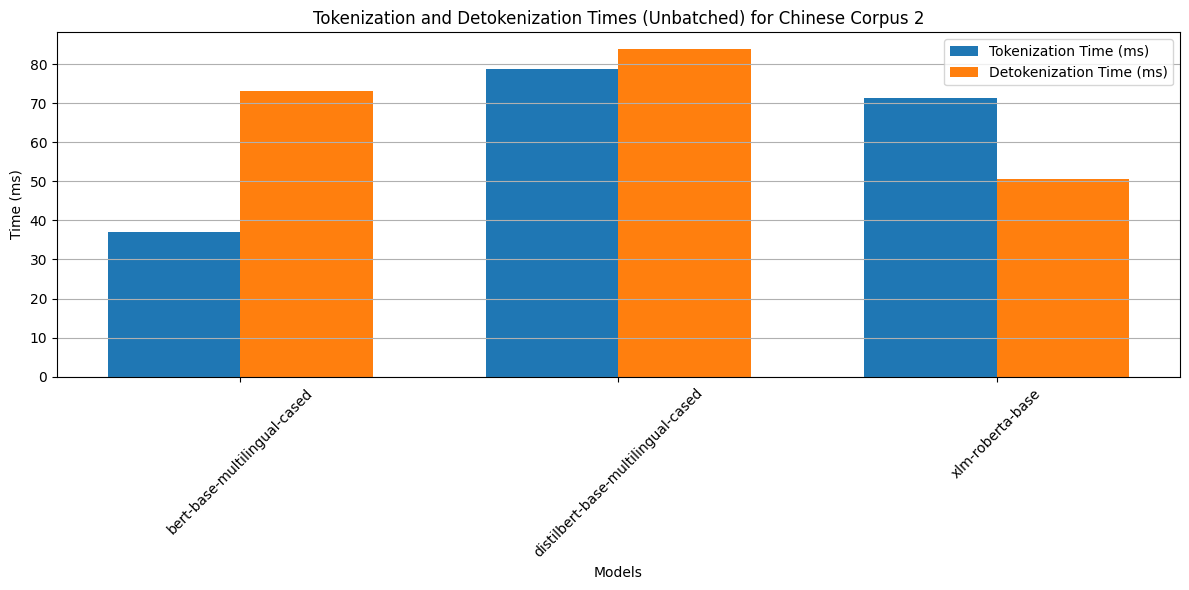

In [35]:

models = [
  "bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"
]

tokenization_times_unbatched = [
    spanish_corpus1_timing_unbatched[model]['Tokenization'] for model in models
]

detokenization_times_unbatched = [
    chinese_corpus1_timing_unbatched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))


plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_unbatched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_unbatched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


##Spanish corpus 1 token and detoken graph Analysis batched data

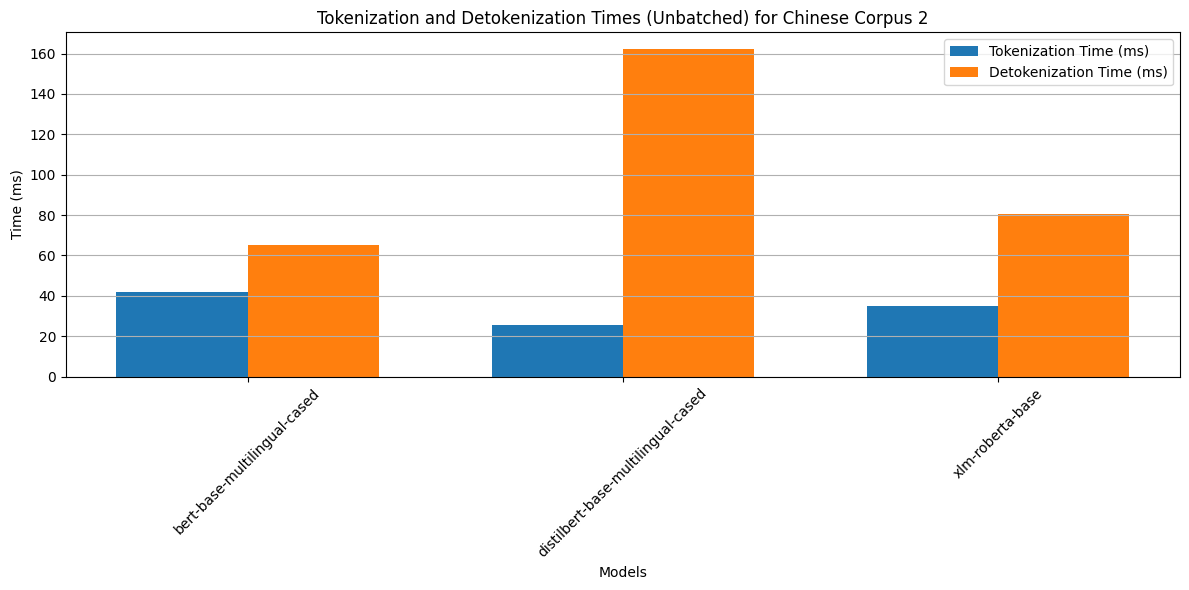

In [36]:

models = [
  "bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"
]

tokenization_times_unbatched = [
    spanish_corpus1_timing_batched[model]['Tokenization'] for model in models
]

detokenization_times_unbatched = [
    chinese_corpus1_timing_batched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_unbatched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_unbatched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


##Spanish corpus 2 token and detoken graph analysis unbatched data

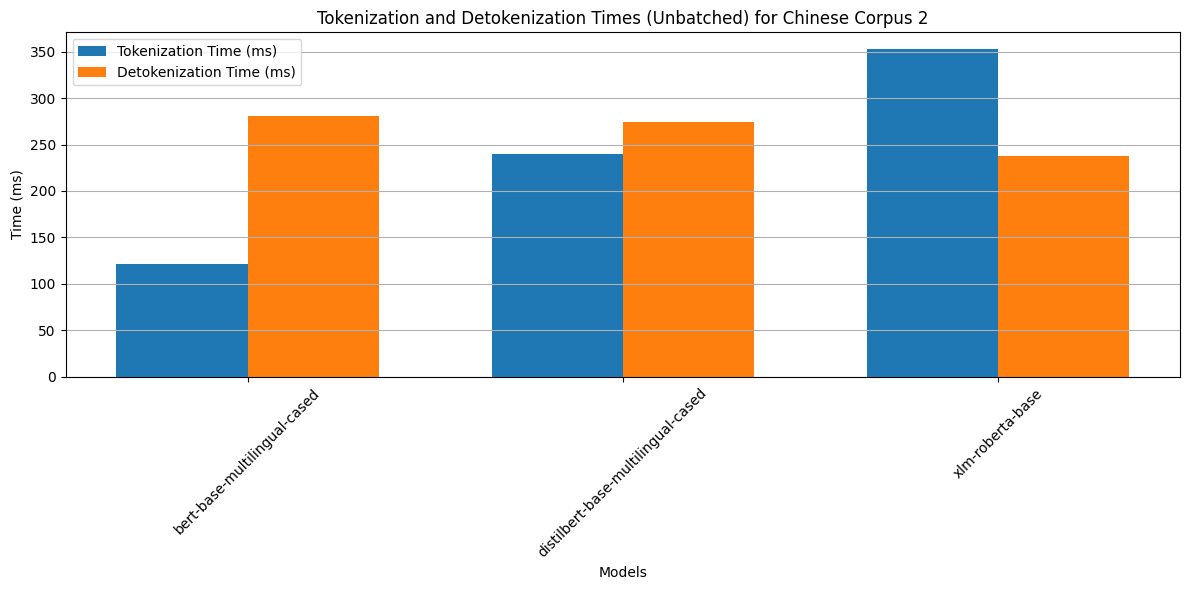

In [37]:

models = [
  "bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"
]

tokenization_times_unbatched = [
    spanish_corpus2_timing_unbatched[model]['Tokenization'] for model in models
]

detokenization_times_unbatched = [
    chinese_corpus2_timing_unbatched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))


plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_unbatched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_unbatched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


##Spanish corpus 2 token and detoken graph analysis batched data

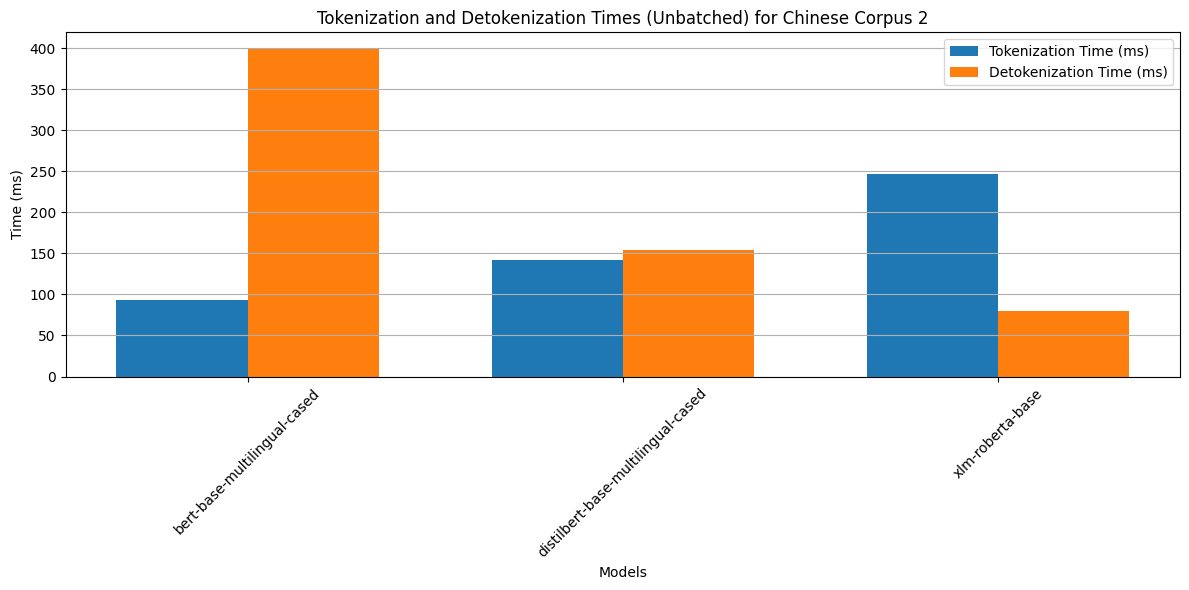

In [38]:
# Data for chinese_corpus2_timing_unbatched
models = [
  "bert-base-multilingual-cased", "distilbert-base-multilingual-cased", "xlm-roberta-base"
]

tokenization_times_unbatched = [
    spanish_corpus2_timing_batched[model]['Tokenization'] for model in models
]

detokenization_times_unbatched = [
    chinese_corpus2_timing_batched[model]['Detokenization'] for model in models
]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(models))

# Create bar chart for chinese_corpus2_timing_unbatched
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width/2, tokenization_times_unbatched, bar_width, label='Tokenization Time (ms)')
plt.bar(index + bar_width/2, detokenization_times_unbatched, bar_width, label='Detokenization Time (ms)')
plt.xlabel('Models')
plt.ylabel('Time (ms)')
plt.title('Tokenization and Detokenization Times (Unbatched) for Chinese Corpus 2')
plt.xticks(index, models, rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()


In [23]:
print(byte_pair_timing_unbatched)
print(byte_pair_timing_batched)
print(word_piece_timing_unbatched)
print(word_piece_timing_batched)
print(sentence_piece_timing_unbatched)
print(sentence_piece_timing_batched)
print(unigram_timing_unbatched)
print(unigram_timing_batched)
print(chinese_corpus1_timing_unbatched)
print(chinese_corpus1_timing_batched)
print(chinese_corpus2_timing_unbatched)
print(chinese_corpus2_timing_batched)
print(spanish_corpus1_timing_unbatched)
print(spanish_corpus1_timing_batched)
print(spanish_corpus2_timing_unbatched)
print(spanish_corpus2_timing_batched)

{'method': 'Unbatched', 'openai-gpt': {'Tokenization': 23.493051528930664, 'Detokenization': 8274.685621261597}, 'gpt2': {'Tokenization': 28.712749481201172, 'Detokenization': 27.922868728637695}, 'NousResearch/Llama-2-13b-hf': {'Tokenization': 25.57992935180664, 'Detokenization': 33.15925598144531}}
{'method': 'Batched', 'openai-gpt': {'Tokenization': 13.199567794799805, 'Detokenization': 21.755695343017578}, 'gpt2': {'Tokenization': 12.187004089355469, 'Detokenization': 22.495746612548828}, 'NousResearch/Llama-2-13b-hf': {'Tokenization': 19.573211669921875, 'Detokenization': 25.72464942932129}}
{'method': 'Unbatched', 'distilbert-base-uncased': {'Tokenization': 20.777463912963867, 'Detokenization': 30.34043312072754}, 'google/mobilebert-uncased': {'Tokenization': 40.883779525756836, 'Detokenization': 60.217857360839844}, 'funnel-transformer/small-base': {'Tokenization': 46.176910400390625, 'Detokenization': 58.12668800354004}, 'sentence-transformers/all-mpnet-base-v2': {'Tokenization

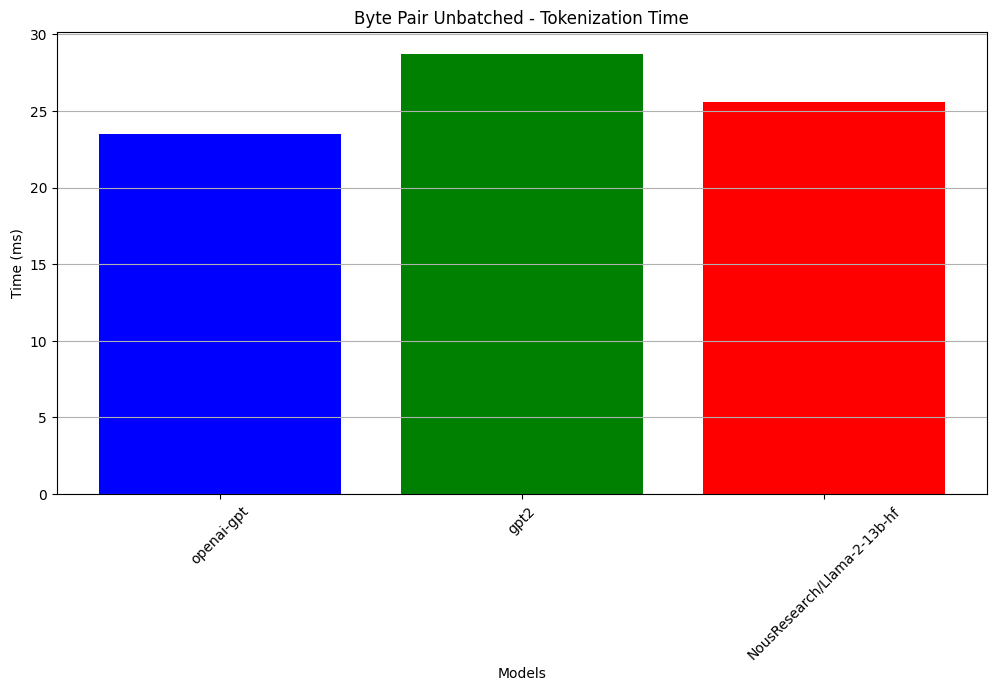

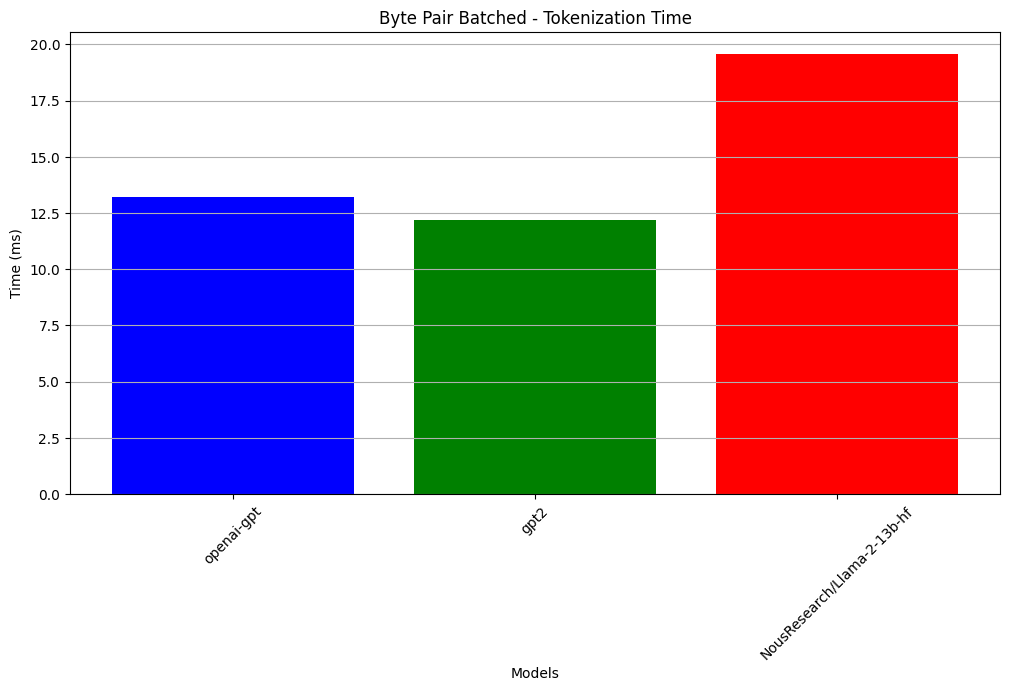

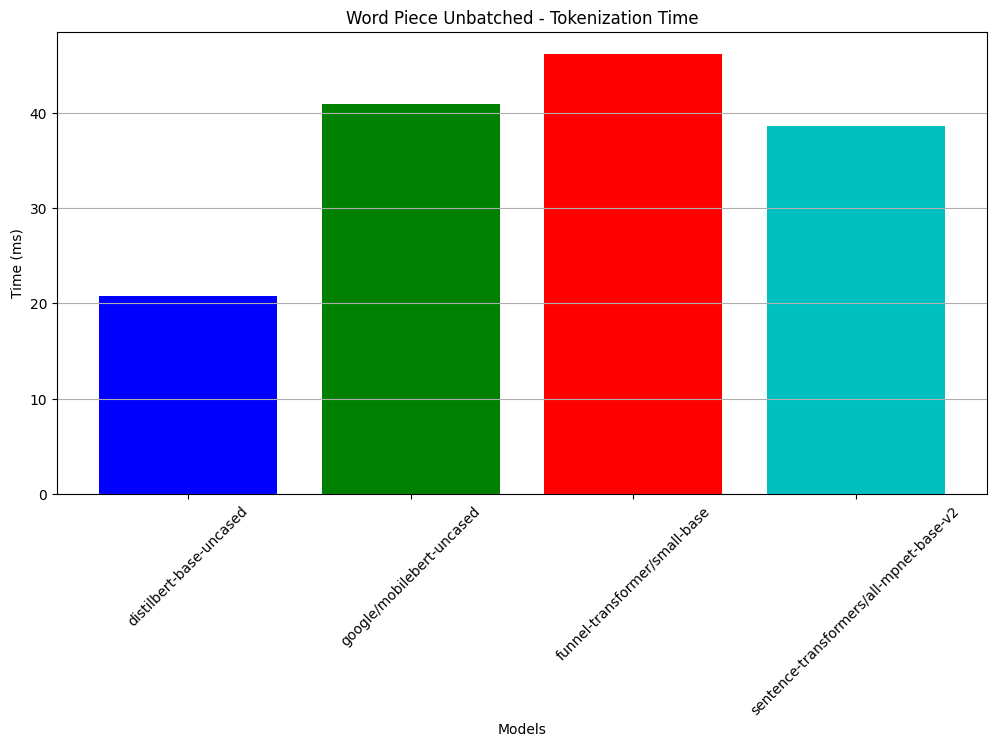

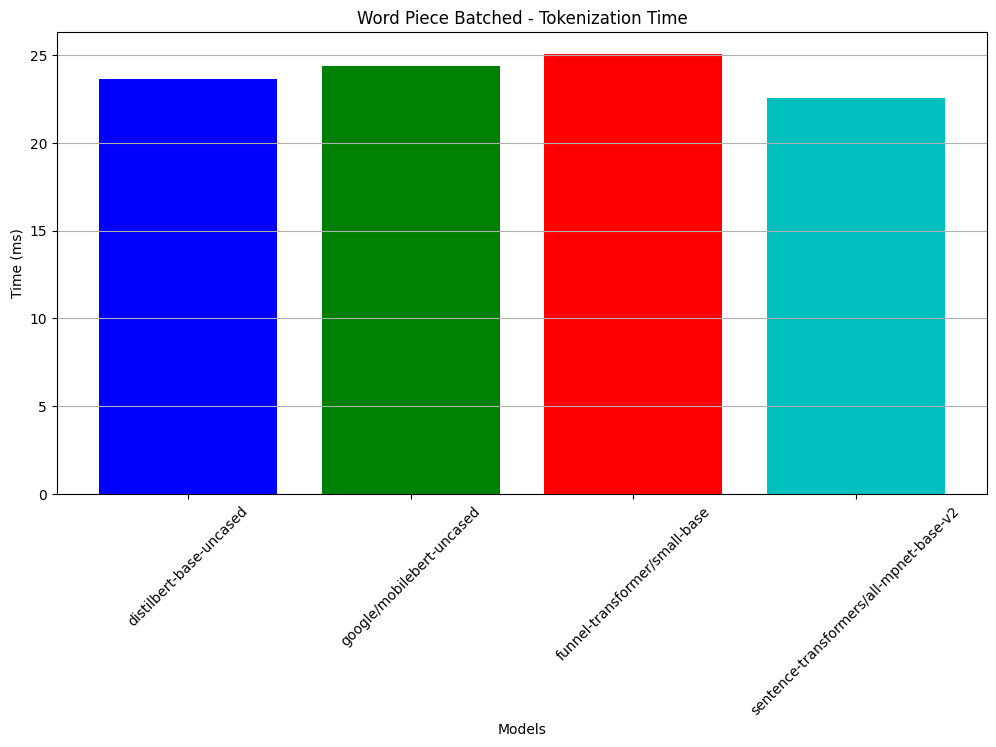

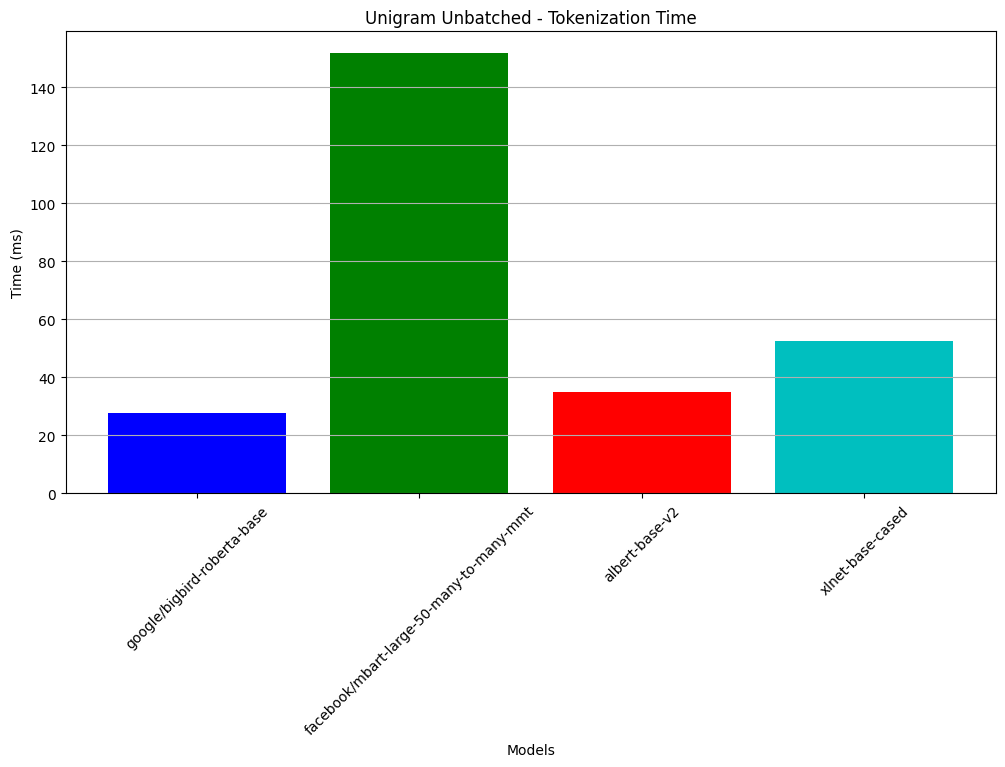

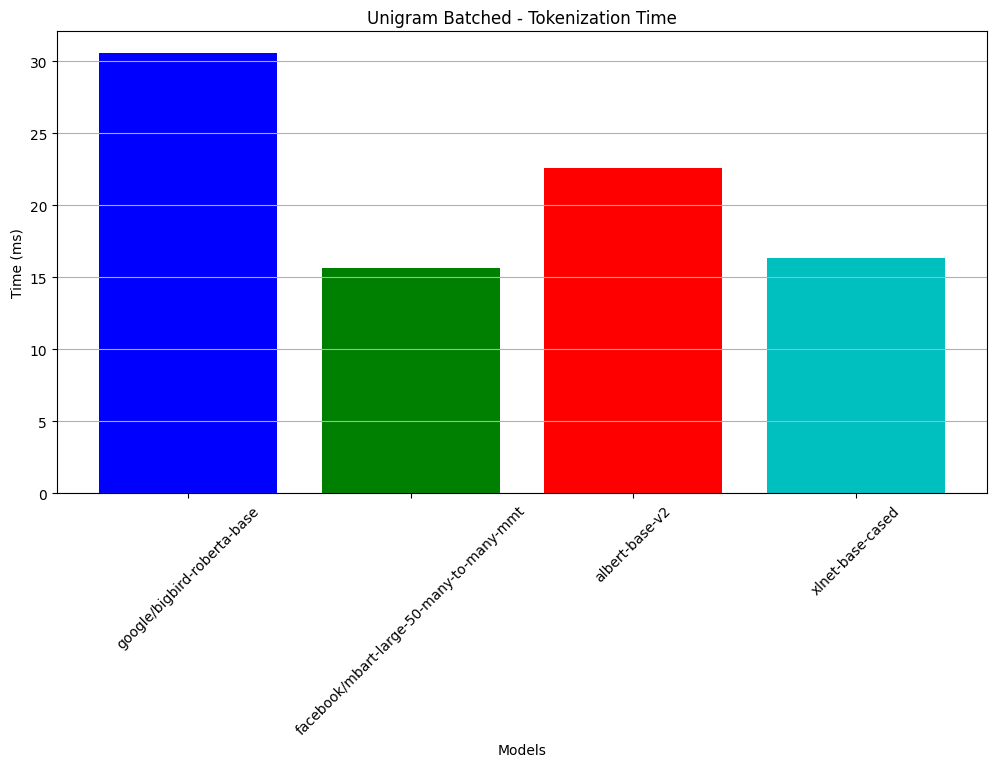

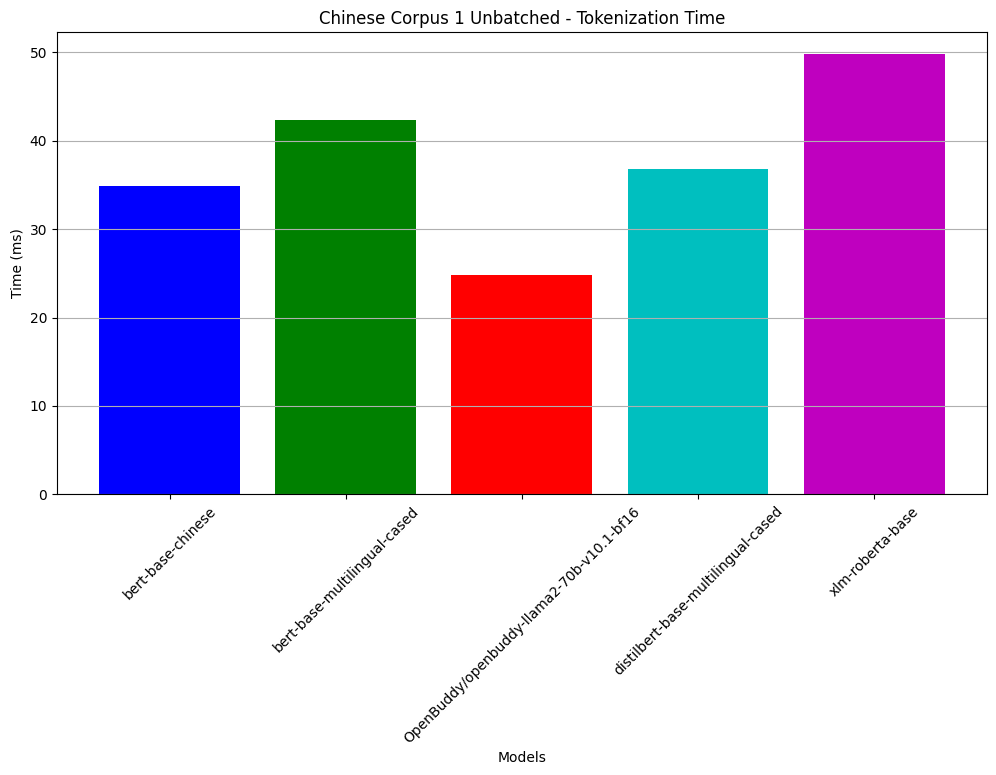

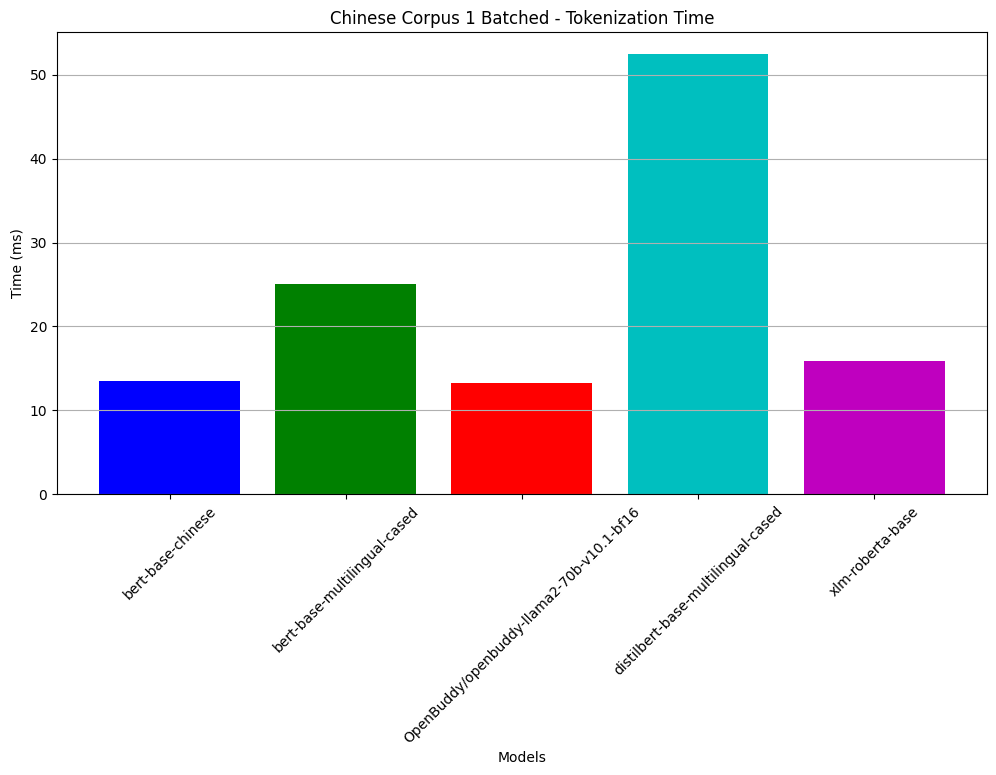

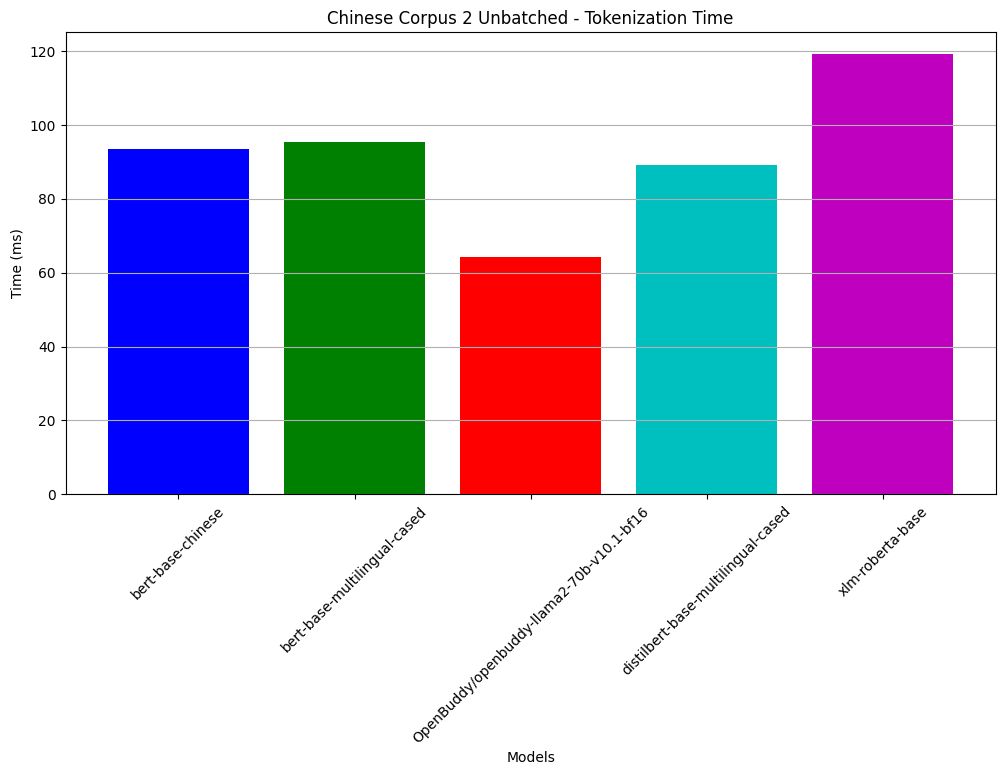

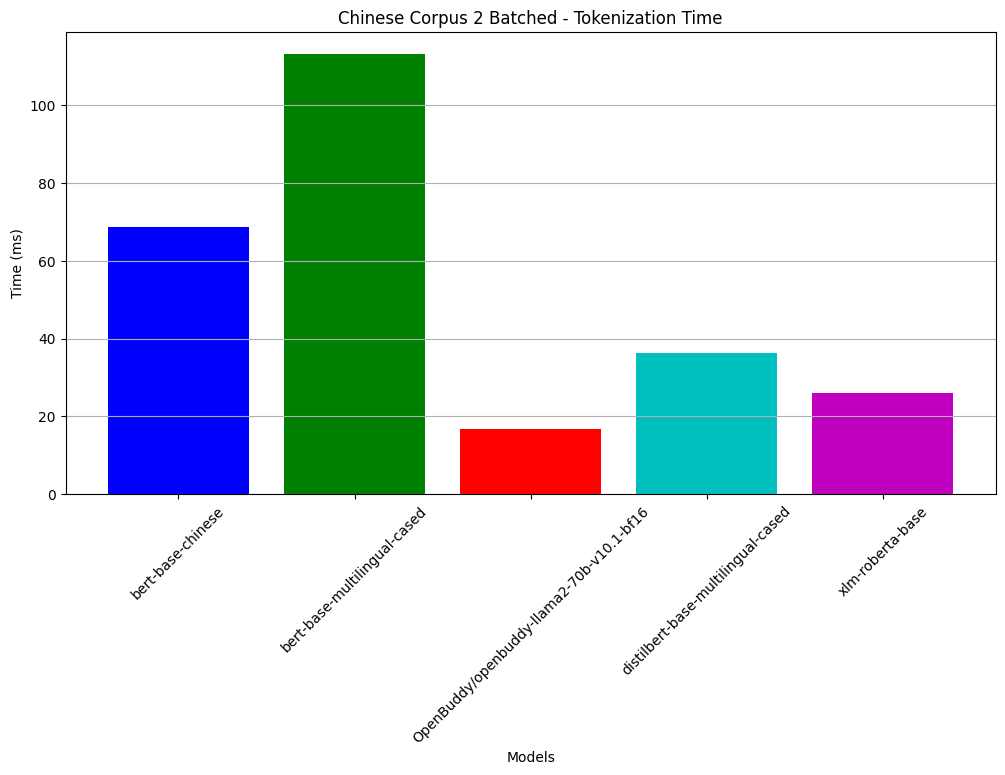

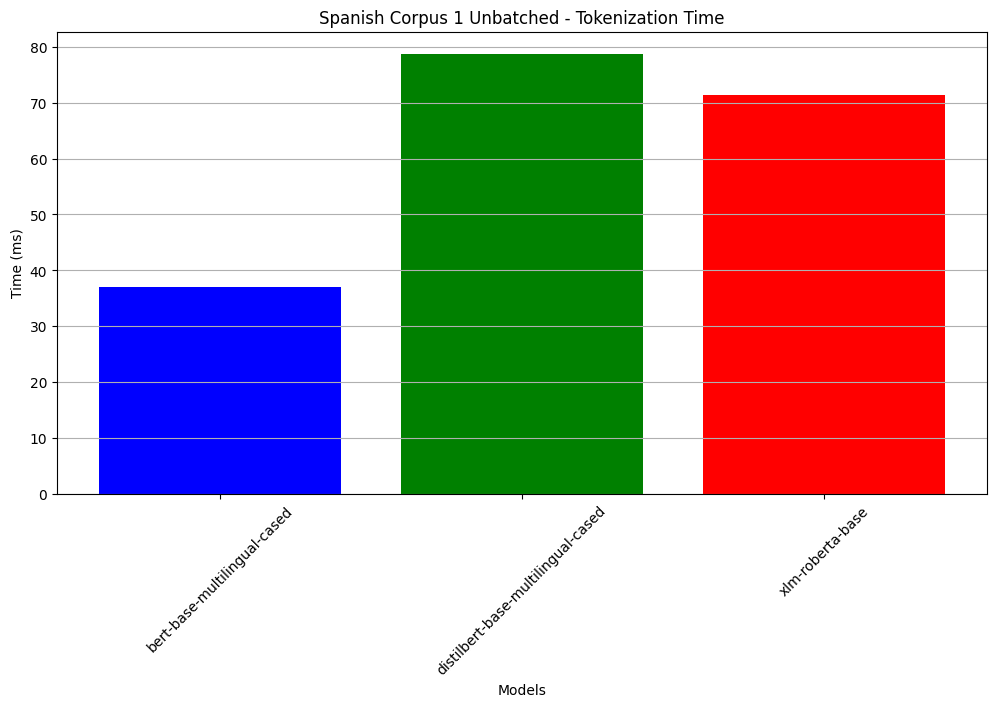

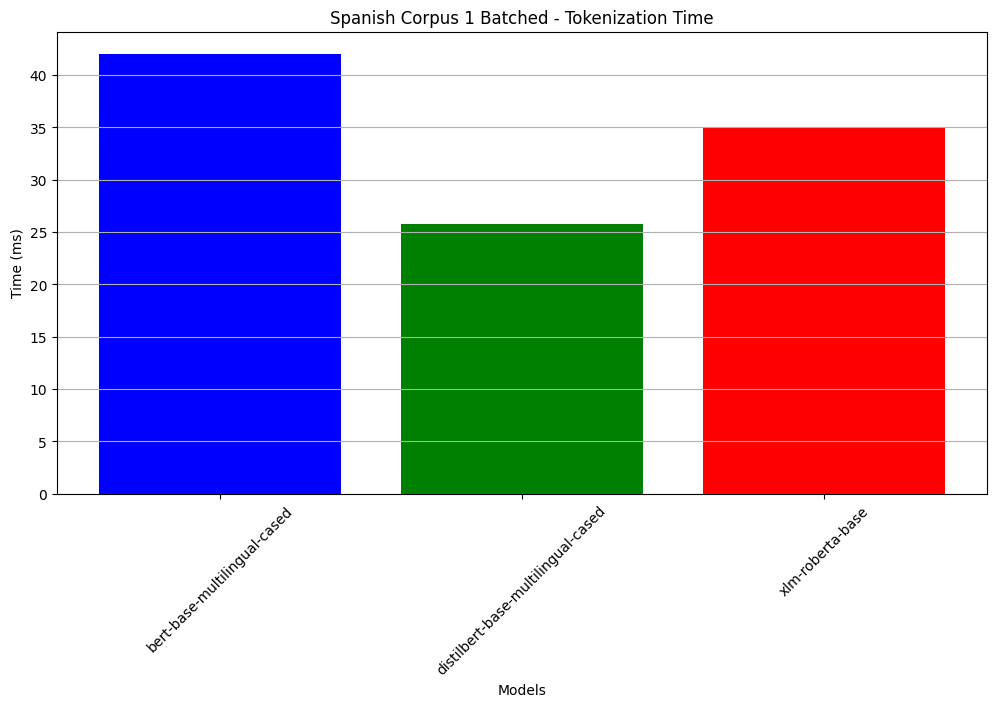

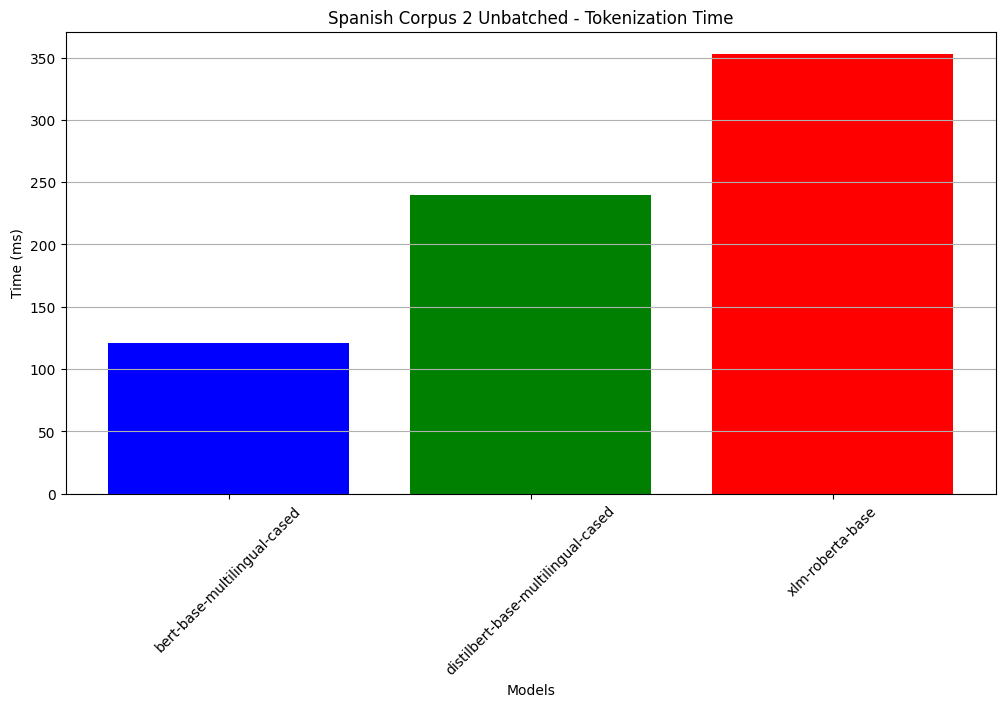

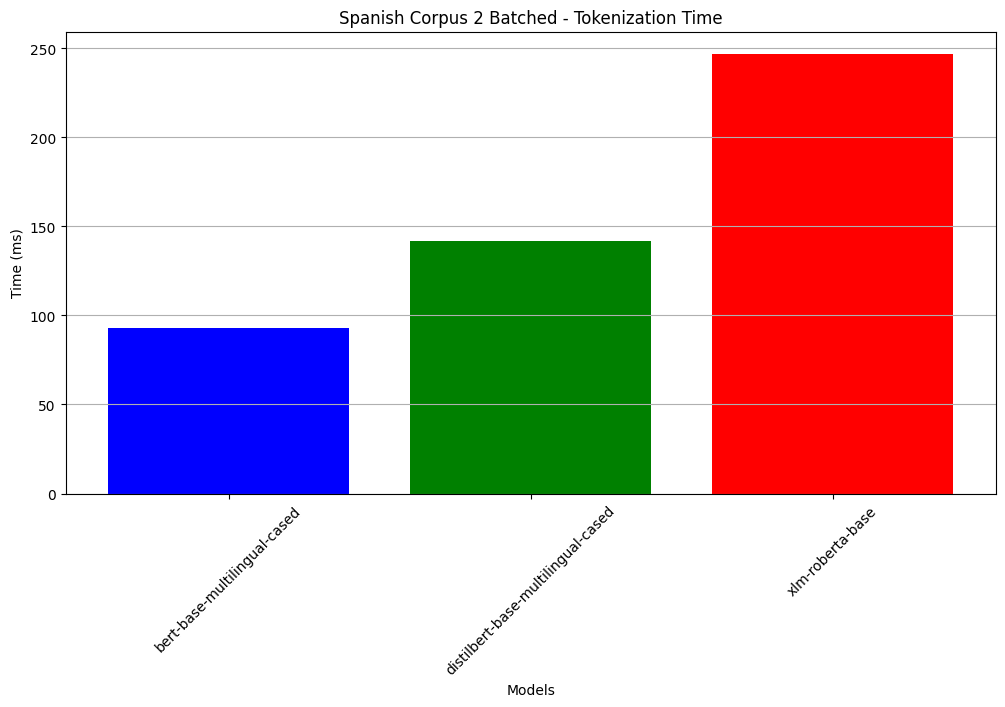

In [57]:
import matplotlib.pyplot as plt

# Define colors for the bars
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500', '#00FF00', '#800080', '#FF00FF', '#008080', '#FFFF00', '#808080', '#800000', '#FF0000']

# Define the data and labels (same as before)
data = [
    byte_pair_timing_unbatched,
    byte_pair_timing_batched,
    word_piece_timing_unbatched,
    word_piece_timing_batched,
    unigram_timing_unbatched,
    unigram_timing_batched,
    chinese_corpus1_timing_unbatched,
    chinese_corpus1_timing_batched,
    chinese_corpus2_timing_unbatched,
    chinese_corpus2_timing_batched,
    spanish_corpus1_timing_unbatched,
    spanish_corpus1_timing_batched,
    spanish_corpus2_timing_unbatched,
    spanish_corpus2_timing_batched
]

labels = [
    'Byte Pair Unbatched',
    'Byte Pair Batched',
    'Word Piece Unbatched',
    'Word Piece Batched',
    'Unigram Unbatched',
    'Unigram Batched',
    'Chinese Corpus 1 Unbatched',
    'Chinese Corpus 1 Batched',
    'Chinese Corpus 2 Unbatched',
    'Chinese Corpus 2 Batched',
    'Spanish Corpus 1 Unbatched',
    'Spanish Corpus 1 Batched',
    'Spanish Corpus 2 Unbatched',
    'Spanish Corpus 2 Batched'
]

# Create bar graphs with colors
for i in range(len(data)):
    plt.figure(figsize=(12, 6))
    plt.title(f"{labels[i]} - Tokenization Time")
    plt.xlabel('Models')
    plt.ylabel('Time (ms)')

    methods = []
    tokenization_times = []

    for method, times in data[i].items():
        if method == 'method':
            continue
        methods.append(method)
        tokenization_time = times.get('Tokenization', 0.0)
        tokenization_times.append(tokenization_time)

    plt.bar(methods, tokenization_times, color=colors)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()
